In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Multimodal retail recommendation: using Gemini to recommend items based on images and image reasoning

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/retail/multimodal_retail_recommendations.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/retail/multimodal_retail_recommendations.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/retail/multimodal_retail_recommendations.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>


## Overview

For retail companies, recommendation systems improve customer experience and thus can increase sales.

This notebook shows how you can use the multimodal capabilities of Gemini Pro Vision model to rapidly create a multimodal recommendation system out-of-the-box.

## Scenario

The customer shows you their living room:

|Customer photo |
|:-----:|
|<img src="https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/rooms/spacejoy-c0JoR_-2x3E-unsplash.jpg" width="80%">  |



Below are four chair options that the customer is trying to decide between:

|Chair 1| Chair 2 | Chair 3 | Chair 4 |
|:-----:|:----:|:-----:|:----:|
| <img src="https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/cesar-couto-OB2F6CsMva8-unsplash.jpg" width="80%">|<img src="https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/daniil-silantev-1P6AnKDw6S8-unsplash.jpg" width="80%">|<img src="https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/ruslan-bardash-4kTbAMRAHtQ-unsplash.jpg" width="80%">|<img src="https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/scopic-ltd-NLlWwR4d3qU-unsplash.jpg" width="80%">|


How can you use Gemini Pro Vision, a multimodal model, to help the customer choose the best option, and also explain why?

### Objectives

Your main objective is to learn how to create a recommendation system that can provide both recommendations and explanations using a multimodal model: Gemini Pro Vision.

In this notebook, you will begin with a scene (e.g. a living room) and use the Gemini Pro Vision model to perform visual understanding. You will also investigate how the Gemini Pro Vision model can be used to recommend an item (e.g. a chair) from a list of furniture items as input.

By going through this notebook, you will learn:
- how to use the Gemini Pro Vision model to perform visual understanding
- how to take multimodality into consideration in prompting for the Gemini Pro Vision model
- how the Gemini Pro Vision model can be used to create retail recommendation applications out-of-the-box

### Costs
This tutorial uses billable components of Google Cloud:

- Vertex AI

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Getting Started

### Install Vertex AI SDK for Python

In [ ]:
! pip3 install --upgrade --user google-cloud-aiplatform

### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [2]:
# Restart kernel after installs so that your environment can access the new packages
import IPython
import time

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>



### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).

In [ ]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Define Google Cloud project information (Colab only)

If you are running this notebook on Google Colab, specify the Google Cloud project information to use. In the following cell, you specify your project information, import the Vertex AI package, and initialize the package. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).

In [ ]:
if "google.colab" in sys.modules:
    # Define project information
    PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
    LOCATION = "us-central1"  # @param {type:"string"}

    # Initialize Vertex AI
    import vertexai

    vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries

In [1]:
from vertexai.preview.generative_models import GenerativeModel, Image

## Using Gemini Pro Vision model

The Gemini Pro Vision model `gemini-pro-vision` is a multimodal model that supports adding image and video in text or chat prompts for a text response.

### Load Gemini Pro Vision model

In [2]:
multimodal_model = GenerativeModel("gemini-pro-vision")

### Define helper functions

In [3]:
import http.client
import io
import typing
import urllib.request

import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps


def display_image(image: Image, max_width: int = 600, max_height: int = 350) -> None:
    pil_image = typing.cast(PIL_Image.Image, image._pil_image)
    if pil_image.mode != "RGB":
        # Modes such as RGBA are not yet supported by all Jupyter environments
        pil_image = pil_image.convert("RGB")
    image_width, image_height = pil_image.size
    if max_width < image_width or max_height < image_height:
        # Resize to display a smaller notebook image
        pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
    display_image_compressed(pil_image)


def display_image_compressed(pil_image: PIL_Image.Image) -> None:
    image_io = io.BytesIO()
    pil_image.save(image_io, "jpeg", quality=80, optimize=True)
    image_bytes = image_io.getvalue()
    ipython_image = IPython.display.Image(image_bytes)
    IPython.display.display(ipython_image)


def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        if response.headers["Content-Type"] not in ("image/png", "image/jpeg"):
            raise Exception("Image can only be in PNG or JPEG format")
        image_bytes = response.read()
    return image_bytes


def load_image_from_url(image_url: str) -> Image:
    image_bytes = get_image_bytes_from_url(image_url)
    return Image.from_bytes(image_bytes)


def print_multimodal_prompt(contents: list):
    """
    Given contents that would be sent to Gemini,
    output the full multimodal prompt for ease of readability.
    """
    for content in contents:
        if isinstance(content, Image):
            display_image(content)
        else:
            print(content)

### Visual understanding with Gemini Pro Vision

Here you will ask the Gemini Pro Vision model to describe a room in details from its image. To do that you have to **combine text and image in a single prompt**.

-------Prompt--------
Describe what's visible in this room and the overall atmosphere:


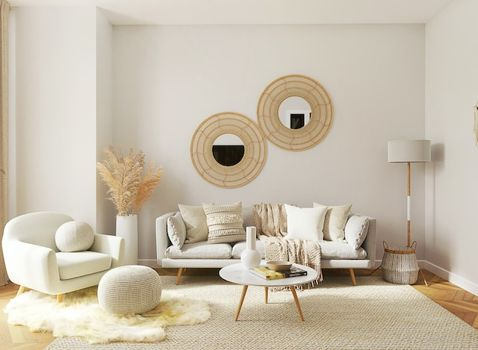


-------Response--------
 This is a living room with a cream-colored sofa, a white coffee table, and a cream-colored rug. There is a gray chair, a gray ottoman, and two wicker mirrors on the wall. There is a tall lamp in the corner and a plant in the corner. The room is decorated in a modern style and has a warm and inviting atmosphere.

In [22]:
# urls for room images
room_image_url = "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/rooms/spacejoy-c0JoR_-2x3E-unsplash.jpg"

# load room images as Image Objects
room_image = load_image_from_url(room_image_url)

prompt = "Describe what's visible in this room and the overall atmosphere:"
contents = [
    prompt,
    room_image,
]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

### Generating open recommendations based on built-in knowledge

Using the same image, you can ask the model to recommend **a piece of furniture** that would fit in it alongside with the description of the room.

Note that the model can choose **any furniture** to recommend in this case, and can do so from its only built-in knowledge.

-------Prompt--------
Recommend a new piece of furniture for this room:


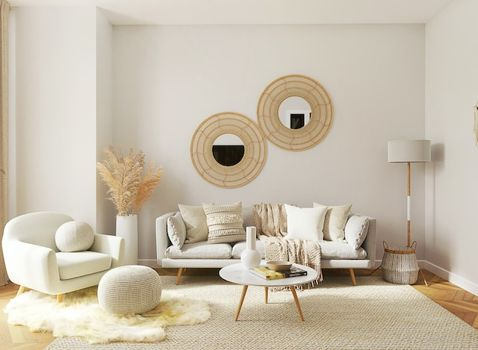

and explain the reason in detail

-------Response--------
 A large, comfortable rug would be a great addition to this room. It would help to define the space and add a touch of warmth and color. A rug would also help to absorb sound and make the room more comfortable to be in.

When choosing a rug, there are a few things to keep in mind. First, the size of the rug should be proportionate to the size of the room. A rug that is too small will look lost, while a rug that is too large will overwhelm the space. Second, the color and pattern of the rug should complement the other colors and patterns in the room. A rug that is too busy will make the room look cluttered, while a rug that is too bland will not add any interest.

Here are a few specific rugs that would work well in this room:

* A large, neutral rug with a geometric pattern would help to define the space and add a touch of warmth.
* A colorful rug with a floral pattern would add a touch of personality and make the room more invi

In [5]:
prompt1 = "Recommend a new piece of furniture for this room:"
prompt2 = "and explain the reason in detail"
contents = [prompt1, room_image, prompt2]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

In the next cell, you will ask the model to recommend **a type of chair** that would fit in it alongside with the description of the room.

Note that the model can choose **any type of chair** to recommend in this case.

-------Prompt--------
Describe this room:


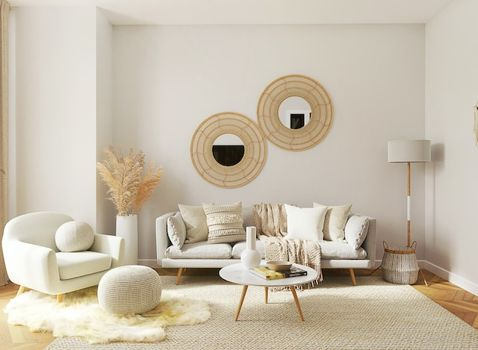

and recommend a type of chair that would fit in it

-------Response--------
 This is a living room with a modern, minimalist style. The room is decorated in neutral colors, with white walls and light wood floors. The furniture is also in neutral colors, with a white sofa, a light wood coffee table, and a white rug. The room is decorated with a few pieces of art, including two mirrors and a vase of pampas grass.

A good type of chair to add to this room would be a wingback chair. A wingback chair is a type of chair that has high back and sides, which makes it very comfortable to sit in. Wingback chairs are also available in a variety of styles, so you can find one that fits the style of your room.

In [6]:
prompt1 = "Describe this room:"
prompt2 = "and recommend a type of chair that would fit in it"
contents = [prompt1, room_image, prompt2]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

### Generating recommendations based on provided images

Instead of keeping the recommendation open, you can also provide a list of items for the model to choose from. Here you will download a few chair images and set them as options for the Gemini model to recommend from. This is particularly useful for retail companies who want to provide recommendations to users based on the kind of room they have, and the available items that the store offers.

-------Prompt--------
Consider the following chairs:
chair 1:


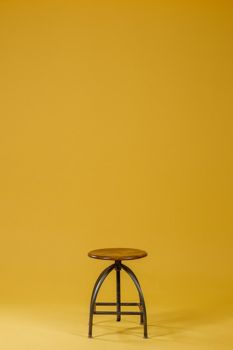

chair 2:


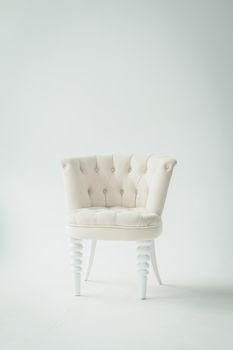

chair 3:


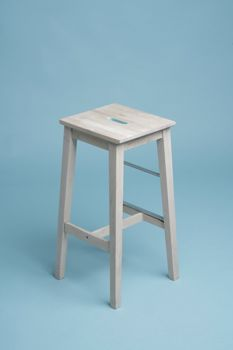

chair 4:


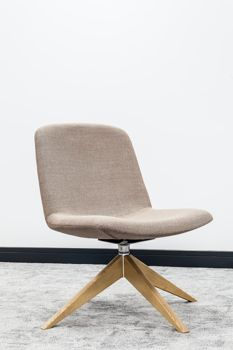

room:


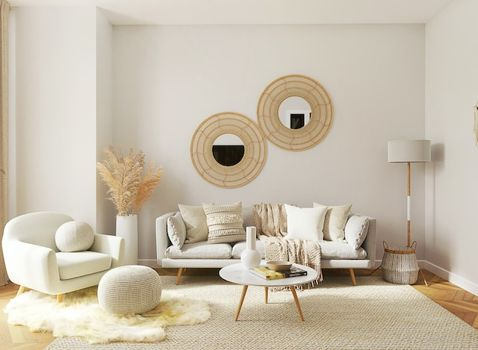

You are an interior designer. For each chair, explain whether it would be appropriate for the style of the room:

-------Response--------
 Chair 1: This chair would not be appropriate for the style of the room. The room is very modern and minimalist, and the chair is very traditional and rustic.

Chair 2: This chair would be appropriate for the style of the room. The chair is very modern and minimalist, and it would complement the other furniture in the room well.

Chair 3: This chair would not be appropriate for the style of the room. The room is very modern and minimalist, and the chair is very traditional and rustic.

Chair 4: This chair would be appropriate for the style of the room. The chair is very modern and minimalist, and it would complement the other furniture in the room well.

In [24]:
# Download and display sample chairs
furniture_image_urls = [
    "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/cesar-couto-OB2F6CsMva8-unsplash.jpg",
    "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/daniil-silantev-1P6AnKDw6S8-unsplash.jpg",
    "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/ruslan-bardash-4kTbAMRAHtQ-unsplash.jpg",
    "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/scopic-ltd-NLlWwR4d3qU-unsplash.jpg",
]

# Load furniture images as Image Objects
furniture_images = [load_image_from_url(url) for url in furniture_image_urls]

# To recommend an item from a selection, you will need to label the item number within the prompt.
# That way you are providing the model with a way to reference each image as you pose a question.
# Labelling images within your prompt also help to reduce hallucinations and overall produce better results.
contents = [
    "Consider the following chairs:",
    "chair 1:",
    furniture_images[0],
    "chair 2:",
    furniture_images[1],
    "chair 3:",
    furniture_images[2],
    "chair 4:",
    furniture_images[3],
    "room:",
    room_image,
    "You are an interior designer. For each chair, explain whether it would be appropriate for the style of the room:",
]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

You can also return the responses in JSON format, to make it easier to plug recommendations into a recommendation system:

-------Prompt--------
Consider the following chairs:
chair 1:


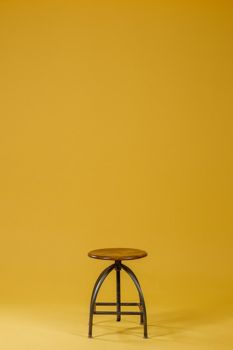

chair 2:


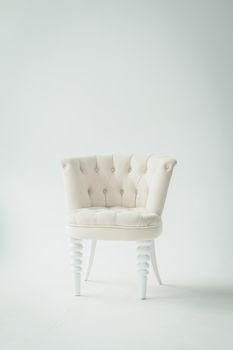

chair 3:


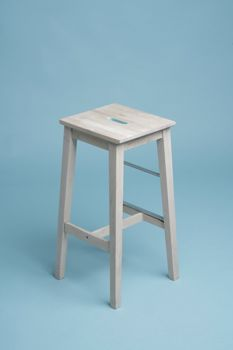

chair 4:


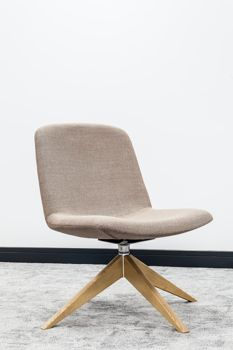

room:


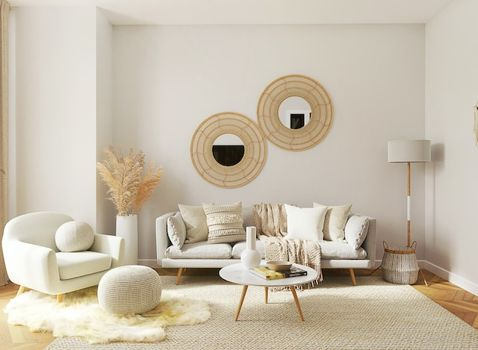

You are an interior designer. Return in JSON, for each chair, whether it would fit in the room, with an explanation:

-------Response--------
 ```json
{
  "chair 1": {
    "fit": false,
    "reason": "The chair is too industrial for the room."
  },
  "chair 2": {
    "fit": true,
    "reason": "The chair is a good fit for the room because it is the same color and style."
  },
  "chair 3": {
    "fit": false,
    "reason": "The chair is too simple for the room."
  },
  "chair 4": {
    "fit": true,
    "reason": "The chair is a good fit for the room because it is the same style."
  }
}
```

In [31]:
contents = [
    "Consider the following chairs:",
    "chair 1:",
    furniture_images[0],
    "chair 2:",
    furniture_images[1],
    "chair 3:",
    furniture_images[2],
    "chair 4:",
    furniture_images[3],
    "room:",
    room_image,
    "You are an interior designer. Return in JSON, for each chair, whether it would fit in the room, with an explanation:",
]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

## Conclusion

This notebook showed how you can easily build a multimodal recommendation system using Gemini for furniture, but you can also use the similar approach in:

- recommending clothes based on an occasion or an image of the venue
- recommending wallpaper based on the room and settings

You may also want to explore how you can build a RAG (retrieval-augmented generation) system where you retrieve relevant images from your store inventory to users who can they use Gemini to help identify the most ideal choice from the various options provided, and also explain the rationale to users.